## Machine Learning 2021 Spring 
## HW3
### Antonio Campbell, Sinta Sulistyo, Atta Ullah, Penny Wu

### 1. Using Cross Validation to choose k for kNN
Use 5-fold cross-validation to choose k. Plot the data and then add the fit using the k you chose using cross-validation and the k you choose by eye-ball.

In [1]:
### import

### basic 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math

import seaborn as sns; #sns.set()



##sklearn learners
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

##sklearn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

##sklearn model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV


In [2]:
%matplotlib inline

#### Import the data from the website and plot the data.

Text(0, 0.5, 'price')

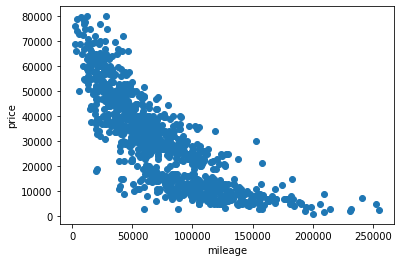

In [3]:
### read in boston data
cd = pd.read_csv("http://www.rob-mcculloch.org/data/susedcars.csv")
cd = cd[['price','mileage']]

#pull off price and mileage
y = cd['price']
X = cd['mileage'].values[:,np.newaxis]

#plot x vs. y
plt.scatter(X,y)
plt.xlabel('mileage')
plt.ylabel('price')


### 5-fold cross validation

In [10]:
###  cross validation using sklearn cross_val_score

# to see a list of scorers:
# sorted(sklearn.metrics.SCORERS.keys()) 

#model object
tempmod = KNeighborsRegressor(n_neighbors=45) #knn with k=40

## rmse from cross validation
cvres = cross_val_score(tempmod,X,y,cv=5,scoring='neg_mean_squared_error') #cross val with 5 folds

# tranform to rmse
rmse = math.sqrt(np.mean(-cvres)) 
print('the rmse for k=45 based on 5-fold is:', rmse)

## do it again but shuffle the data
np.random.seed(34) 
indices = np.random.choice(X.shape[0],X.shape[0],replace=False)
ys = y[indices]
Xs = X[indices,:]
cvres = cross_val_score(tempmod,Xs,ys,cv=5,scoring='neg_mean_squared_error')
rmse = math.sqrt(np.mean(-cvres))
print('the rmse for k=45 based on 5-fold is:', rmse)


the rmse for k=45 based on 5-fold is: 9326.337732231708
the rmse for k=45 based on 5-fold is: 9247.309070177798


#### 5-fold cross validation via `validation_curve`

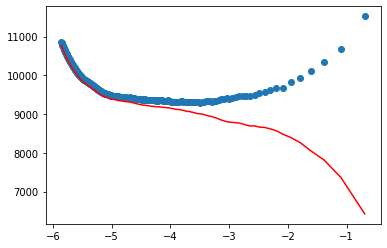

In [12]:
kvec = np.arange(348) + 2 #values of k to try
mcmp = np.log(1/kvec) #model complexity
###  cross validation on a grid of k values using sklearn validation_curve function

# create the knn model
model = KNeighborsRegressor() # create the knn model

# do cv at every value of k in kvec
trainS, testS = validation_curve(model,X,y,'n_neighbors',kvec,cv=5,scoring='neg_mean_squared_error')


# transform neg_mean_squared_error to rmse
trrmse = np.sqrt(-trainS.mean(axis=1))
termse = np.sqrt(-testS.mean(axis=1))



#### Plot the train and test scores

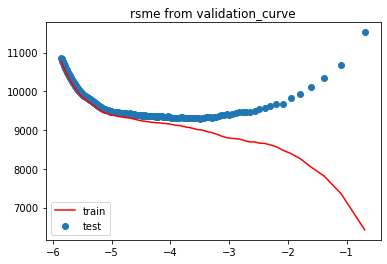

In [17]:
#plot in and out of sample rmse
plt.scatter(mcmp,termse,label='test')
plt.plot(mcmp,trrmse,c='red',label='train')
plt.title('rsme from validation_curve')
plt.legend()

This is the well-known bias-variance trade-off diagram we have seen in class. The test set scores and training set scores diverge from each other after a threshold of model complexity. Next we will use `GridSearchCV` to do the 5-fold cross validation and it will return the best grid for the choice of k.

33
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Text(0.5, 1.0, 'rmse from GridSearch')

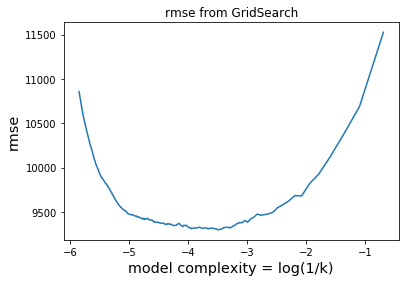

In [13]:
### cross val on a grid using sklearn GridSearchCV

# hyperparamter values to try in the gid search
param_grid={'n_neighbors' : kvec} # same as above

# grid  is the grid searh object
grid = GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')

# now run the grid search
grid.fit(X,y)

grid.best_params_ #best value from grid
grid.best_index_ # index of best value from grid
#check
print(grid.best_params_)
print(kvec[grid.best_index_])


temp = grid.cv_results_ # results from the grid search (a dictionary)
print(temp.keys()) # what is in temp
temp['mean_test_score'] # this is the average score over folds at the values in param_grid

#transform to rmse
rmsevals = np.sqrt(-temp['mean_test_score'])

# plot
plt.plot(mcmp,rmsevals) # plot model complexity vs. rmse
plt.xlabel('model complexity = log(1/k)',size='x-large')
plt.ylabel('rmse',size='x-large')
plt.title('rmse from GridSearch')


#### Compare kNN eye-balled k from HW2 with the 5-fold CV best k.
Our eye-balled k from HW2 is k=45.

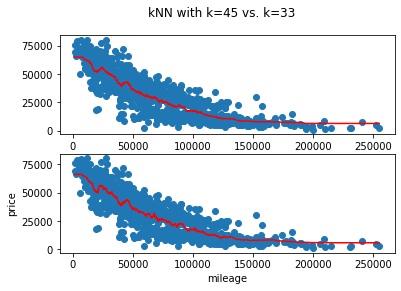

In [30]:
# create model object setting the hyperparameter n_neighbors to 45
knnmod = KNeighborsRegressor(n_neighbors=45)

# fit with training data
knnmod.fit(X,y)

#predict on sorted x training values
Xtest = np.sort(X[:,0])[:,np.newaxis]
yhat = knnmod.predict(Xtest)

knnmod2 = KNeighborsRegressor(n_neighbors=33)

# fit with training data
knnmod2.fit(X,y)
#predict on sorted x training values
yhat2 = knnmod2.predict(Xtest)

#plot fit
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('kNN with k=45 vs. k=33')
ax1.scatter(X,y)
ax1.plot(Xtest,yhat,c='red')
plt.xlabel('mileage')
plt.ylabel('price')

ax2.scatter(X,y)
ax2.plot(Xtest,yhat2,c='r')





#### Predict on mileage=100,000 with k=33

In [37]:
out = knnmod2.predict([[100000]])
print('prediction for price with mileage=100,000: $',out[0])

prediction for price with mileage=100,000: $ 17751.666666666668


### 2. Use kNN to get a prediction for a 2008 car with 75,000 miles on it

In [38]:
cd = pd.read_csv("http://www.rob-mcculloch.org/data/susedcars.csv")
cd = cd[['price','mileage','year']]
cd['price'] = cd['price']/1000
cd['mileage'] = cd['mileage']/1000

Text(0.5, 1.0, 'price against year')

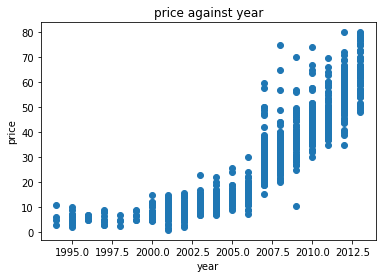

In [49]:
y = cd['price']
X = cd[['mileage','year']]

#plot price vs year
plt.scatter(X['year'],y)
plt.xlabel('year')
plt.ylabel('price')
plt.title('price against year')

Let us use `validation_curve` to show the examine the bias-variance trade-off.

In [52]:
kvec = np.arange(390) + 2 #values of k to try
mcmp = np.log(1/kvec) #model complexity
# ###  cross validation on a grid of k values using sklearn validation_curve function

# create the knn model
model = KNeighborsRegressor() # create the knn model

# do cv at every value of k in kvec
trainS, testS = validation_curve(model,X,y,'n_neighbors',kvec,cv=5,scoring='neg_mean_squared_error')


# transform neg_mean_squared_error to rmse
trrmse = np.sqrt(-trainS.mean(axis=1))
termse = np.sqrt(-testS.mean(axis=1))




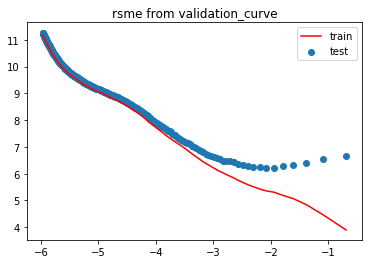

In [53]:
#plot in and out of sample rmse
plt.scatter(mcmp,termse,label='test')
plt.plot(mcmp,trrmse,c='red',label='train')
plt.title('rsme from validation_curve')
plt.legend()

{'n_neighbors': 8}
8
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Text(0.5, 1.0, 'rmse from GridSearch')

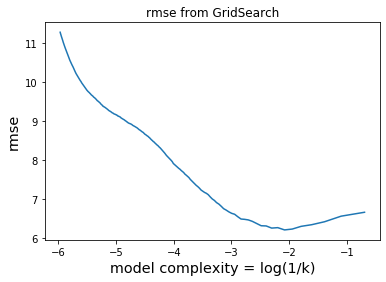

In [54]:
# grid  is the grid searh object
param_grid={'n_neighbors' : kvec}
grid = GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')

# now run the grid search
grid.fit(X,y)

grid.best_params_ #best value from grid
grid.best_index_ # index of best value from grid
#check
print(grid.best_params_)
print(kvec[grid.best_index_])


temp = grid.cv_results_ # results from the grid search (a dictionary)
#print(temp.keys()) # what is in temp
#temp['mean_test_score'] # this is the average score over folds at the values in param_grid

#transform to rmse
rmsevals = np.sqrt(-temp['mean_test_score'])

# plot
plt.plot(mcmp,rmsevals) # plot model complexity vs. rmse
plt.xlabel('model complexity = log(1/k)',size='x-large')
plt.ylabel('rmse',size='x-large')
plt.title('rmse from GridSearch')



In [62]:
knnmod3 = KNeighborsRegressor(n_neighbors=8)
knnmod3.fit(X,y)
yhat3 = knnmod3.predict(X)
k8mse = mean_squared_error(y,yhat3)
k33mse = mean_squared_error(y,yhat2/1000)
print('rmse for k=8:', math.sqrt(k8mse))
print('rmse for k=33 with only mileage:', math.sqrt(k33mse))

rmse for k=8: 5.369450129454889
rmse for k=33 with only mileage: 24.019161759869682


The rmse of kNN with mileage and year is significantly smaller than the rmse of kNN with only mileage. So adding year does improbve prediction accuracy.

In [60]:
out = knnmod3.predict([[75,2008]])
print('prediction for a 2008 car with 75,000 miles: ', out[0]*1000)

prediction for a 2008 car with 75,000 miles:  29997.374999999996


### 3. Choice of Kernel: use a weighting option instead of uniform

We will use the 'distance' option for weights. The closer points of a query point will be given bigger weights.

In [63]:
model = KNeighborsRegressor(weights='distance')

{'n_neighbors': 10}
10


Text(0.5, 1.0, 'rmse from GridSearch')

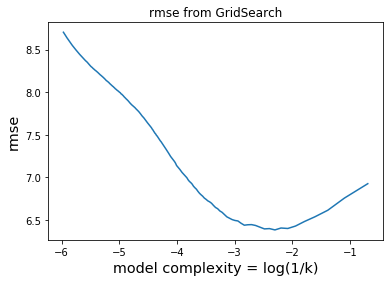

In [64]:
grid = GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')

# now run the grid search
grid.fit(X,y)

grid.best_params_ #best value from grid
grid.best_index_ # index of best value from grid
#check
print(grid.best_params_)
print(kvec[grid.best_index_])


temp = grid.cv_results_ # results from the grid search (a dictionary)
#print(temp.keys()) # what is in temp
#temp['mean_test_score'] # this is the average score over folds at the values in param_grid

#transform to rmse
rmsevals = np.sqrt(-temp['mean_test_score'])

# plot
plt.plot(mcmp,rmsevals) # plot model complexity vs. rmse
plt.xlabel('model complexity = log(1/k)',size='x-large')
plt.ylabel('rmse',size='x-large')
plt.title('rmse from GridSearch')

The best k given by 5-fold CV with a weighting option is k=10.

In [66]:
knnmod4 = KNeighborsRegressor(n_neighbors=10,weights='distance')
knnmod4.fit(X,y)
yhat4 = knnmod4.predict(X)
k10mse = mean_squared_error(y,yhat4)

print('rmse for k=10 with weighting option:', k10mse)


rmse for k=10 with weighting option: 0.0
